In [157]:
#Importing Necessary Data Corpus and Libraries
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.optimizers import SGD
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import nltk
import keras
import tensorflow as tf

nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('stopwords')
NEGATE = {
    "n't",
    "aint",
    "arent",
    "cannot",
    "cant",
    "couldnt",
    "darent",
    "didnt",
    "doesnt",
    "ain't",
    "aren't",
    "can't",
    "couldn't",
    "daren't",
    "didn't",
    "doesn't",
    "dont",
    "hadnt",
    "hasnt",
    "havent",
    "isnt",
    "mightnt",
    "mustnt",
    "neither",
    "don't",
    "hadn't",
    "hasn't",
    "haven't",
    "isn't",
    "mightn't",
    "mustn't",
    "neednt",
    "needn't",
    "never",
    "none",
    "nope",
    "nor",
    "not",
    "nothing",
    "nowhere",
    "oughtnt",
    "shant",
    "shouldnt",
    "uhuh",
    "wasnt",
    "werent",
    "oughtn't",
    "shan't",
    "shouldn't",
    "uh-uh",
    "wasn't",
    "weren't",
    "without",
    "wont",
    "wouldnt",
    "won't",
    "wouldn't",
    "rarely",
    "seldom",
    "despite",
}

positive_file = open('positive-words.txt', 'r')
POSITIVE = positive_file.read().splitlines()
positive_file.close()

negative_file = open('negative-words.txt', 'r')
NEGATIVE = negative_file.read().splitlines()
negative_file.close()



[nltk_data] Downloading package wordnet to
[nltk_data]     /eccs/users/ltdang16/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /eccs/users/ltdang16/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /eccs/users/ltdang16/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /eccs/users/ltdang16/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
#Importing dataset
data_frame = pd.read_json(r'Home_and_Kitchen_5.json', lines = True)

In [159]:
#Changing score-based to label-based
data_frame['overall'] = data_frame['overall'].replace(to_replace=[4, 5], value='Good')
data_frame['overall'] = data_frame['overall'].replace(to_replace=[3], value='Neutral')
data_frame['overall'] = data_frame['overall'].replace(to_replace=[1, 2], value='Bad')
data_frame = data_frame.dropna()
data_frame = data_frame.drop(['asin', 'helpful', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'], axis = 1)
data_frame.overall.value_counts()   #Checking Distribution of Labels

Good       451191
Bad         50931
Neutral     44607
Name: overall, dtype: int64

In [160]:
#Downsample the Good Label for even distributions
data_frame_good = data_frame[data_frame['overall'] == 'Good']
data_frame_neutral = data_frame[data_frame['overall'] == 'Neutral']
data_frame_bad = data_frame[data_frame['overall'] == 'Bad']

data_frame_good = resample(data_frame_good, 
                   replace = False,
                   n_samples = 50000,
                   random_state = 123)
data_frame = pd.concat([data_frame_good, data_frame_bad, data_frame_neutral])


In [161]:
X = data_frame['reviewText']
Y= data_frame['overall']

In [162]:

def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    neg_words = NEGATE
    if any(word.lower() in neg_words for word in input_words):
        return True
    if include_nt:
        if any("n't" in word.lower() for word in input_words):
            return True
    return False

def negated_word(word, include_nt=True):
    """
    Determine if input contains negation words
    """
    neg_words = NEGATE
    if word in neg_words:
        return True
    if include_nt:
        if word == "n't" or word == "t":
            return True
        
    return False

def get_negation_statistic(data_frame):
    """
    Get the statistic of: Count of Negation Word, Maximum amount of Negation word, Average Amount
    """
    #Negation Counter
    total_negation_count = 0
    total_negation_sentence_count = 0
    max_negation_count = 0
    #Total sentence counter
    total_sentence_count = 0
    
    #Sentiment Counter
    total_sentiment_count = 0
    total_negation_sentiment_count = 0
    
    reviewList = data_frame['reviewText'].tolist()
    for sentence in reviewList:
        sentence_tokenizer = word_tokenize(sentence)
        review_negation_count = 0
        review_sentiment_count = 0
        for word in sentence_tokenizer:
            if negated_word(word):
                review_negation_count += 1
            if word == '.': #at the end of the sentence
                total_sentence_count += 1
                if review_negation_count == 0: #There's no negation word
                    pass
                else: #There's a negation
                    if review_negation_count > max_negation_count:
                        max_negation_count = review_negation_count
                    total_negation_count += review_negation_count
                    total_negation_sentence_count += 1
                    review_negation_count = 0
    return total_negation_count, total_negation_sentence_count, total_sentence_count, total_negation_count/total_negation_sentence_count, max_negation_count
    
stop_words = set(stopwords.words('english'))
def get_sentiment(sentence_token):
    """
    Identify and keep track of positive/negative word in a review
    """
    positive_index = []
    negative_index = []
    for wordIndex in range(len(sentence_token)):
        word = sentence_token[wordIndex].lower()
        if word in stop_words or word in NEGATE:
            pass
        else:
            if word in NEGATIVE:
                  negative_index.append(wordIndex)  
            elif word in POSITIVE:
                positive_index.append(wordIndex)
    return positive_index, negative_index

def get_negation(sentence_token):
    """
    Identify and keep track of positive/negative word in a review
    """
    negation_list = []
    pos_after_negation = []
    for wordIndex in range(len(sentence_token)):
        word = sentence_token[wordIndex].lower()
        if negated_word(word):
            negation_list.append(wordIndex)
            
    return negation_list, len(negation_list)
    
def is_closest_sentiment_positive(value, pos_list, neg_list):
    """
    Identify the emotion of the sentiment word in a Negation-Sentiment Word Pair
    """
    smallest = 1000000
    positive = True
    for item in pos_list:
        if item > value and item < smallest:
            smallest = item
    for item in neg_list:
        if item > value and item < smallest:
            positive = False
    if smallest == 1000000:
        positive = None
    return positive

def calculate_negate_sentiment_score(value, pos_list, neg_list):
    """
    Calculate the Negation Score Based of the Distance Between the two words
    """
    is_positive = True
    closest_index = 10000000
    for item in pos_list:
        if item > value and item < closest_index:
            closest_index = item
    for item in neg_list:
        if item > value and item < closest_index:
            closest_index = item
            is_positive = False
    if closest_index == 10000000:
        return 0
    if is_positive == False:
        score = 1/(closest_index - value)
    else:
        score = -1/(closest_index - value)
    
    return score


def preprocess_sentence(sentence):
    """
    Return a vector of features for each review:
    Number of Negation Word, Number of Sentiment Word, Positive Score, Negative Score, Accumulative Score
    """
    vector = []
    sentence_token = nltk.word_tokenize(sentence)
    pos_index , neg_index = get_sentiment(sentence_token)
    negate_index, num_negate = get_negation(sentence_token)
    pos_score = len(pos_index)
    neg_score = len(neg_index)
    num_sent = pos_score + neg_score
    if num_sent == 0:
        return None
    else:
        vector.append(num_negate)
        vector.append(num_sent)
        true_pos = pos_score
        true_neg = neg_score
        negate_score = 0
        for negateIndex in negate_index:
            closest_is_positive = is_closest_sentiment_positive(negateIndex, pos_index, neg_index)
            if closest_is_positive == True:
                true_pos -= 1
            elif closest_is_positive == False:
                true_neg -= 1
            else:
                pass
            negate_score += calculate_negate_sentiment_score(negateIndex, pos_index, neg_index)
        accumulative_score = true_pos + negate_score - true_neg
        vector.append(true_pos)
        vector.append(true_neg)
        vector.append(accumulative_score)
    
        return vector

def preprocess_review(review):
    review_vector = [0,0,0,0,0]
    review_token = sent_tokenize(review)
    for sentence in review_token:
        sentence_vector = preprocess_sentence(sentence)
        if sentence_vector == None:
            pass
        else:
            review_vector = [sum(i) for i in zip(sentence_vector, review_vector)] 
    return review_vector

def preprocess_dataframe(list_review):
    preprocessed = []
    for review in list_review:
        preprocessed.append(preprocess_review(review))
    
    preprocessed_df = pd.DataFrame(preprocessed, columns=["negation_count", "sentiment_count", "positive_count",
                                                         "negative_count", "accumulative_score"])
    return preprocessed_df


In [163]:
#Example of preprocessing a negative review
sentence = "I don't like cake. It's awful"
preprocessed_sentence = preprocess_review(sentence)
preprocessed_sentence

[1, 2, 0, 1, -2.0]

In [169]:
#Preprocess the entire dataset (Warning: It takes approx 1hr)
X = preprocess_dataframe(X)

In [173]:
#Splitting the Preprocessed dataset to train set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, random_state = 123)
train_norm = X_train[X_train.columns[0:6]]
test_norm = X_test[X_test.columns[0:5]]


In [174]:
#Normalize the data to prevent outliers
std_scaler = StandardScaler().fit(train_norm)
X_train_norm = std_scaler.transform(train_norm)
std_scaler_test = StandardScaler().fit(test_norm)
X_test_norm = std_scaler.transform(test_norm)
testing_norm_col = pd.DataFrame(X_test_norm, index=test_norm.index, columns=test_norm.columns)


In [175]:
training_norm_col = pd.DataFrame(X_train_norm, index=train_norm.index, columns=train_norm.columns) 

In [176]:
#Logistic Regression

LogisticRegr = LogisticRegression(solver = 'lbfgs')        #Initialize the Logistic Regression Model
LogisticRegr.fit(training_norm_col, Y_train)               #Model Training
predicted = LogisticRegr.predict(testing_norm_col)         #Model Prediction

/mounts/bowie/software/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [177]:
#Testing Model prediction with a negative review
sentence = "I don't like cake. It's awful"
preprocessed_sentence = preprocess_review(sentence)
LogisticRegr.predict([preprocessed_sentence])

array(['Bad'], dtype=object)

In [178]:
#Testing Model prediction with a positive review
sentence = "I like Computer Science. It's nice"
preprocessed_sentence = preprocess_review(sentence)
LogisticRegr.predict([preprocessed_sentence])

array(['Good'], dtype=object)

In [166]:
print("Accuracy score of the Logistic model is " + str(LogisticRegr.score(testing_norm_col, Y_test)*100))

Accuracy score of the Logistic model is 54.43177133434107


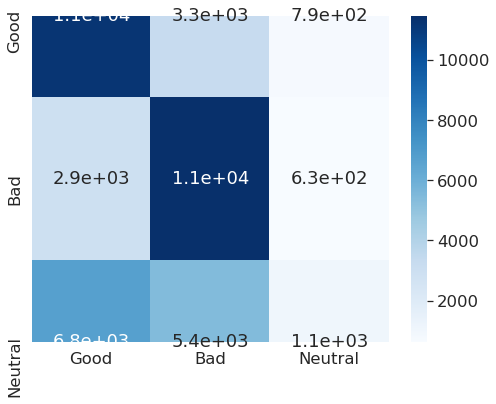

In [72]:
#Heatmap confusion matrix
matrix = metrics.confusion_matrix(Y_test, predicted)
df_matrix = pd.DataFrame(matrix, index=["Good", "Bad", "Neutral"], columns=["Good", "Bad", "Neutral"])
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylim([0,2])
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_matrix, annot=True, cmap='Blues') # font size
plt.show()


In [75]:
#Actual data from the confusion matrix
df_matrix

,Good,Bad,Neutral
Good,11223,3333,794
Bad,2925,11471,633
Neutral,6765,5446,1072


In [147]:
#Neural Network

Y_train = Y_train.astype('category').cat.codes  #Reformating Y-train to fit with Neural Network model
Y_test = Y_test.astype('category').cat.codes    #Reformating Y-train to fit with Neural Network model

model = keras.Sequential([                      #Initialize the Neural Network Model
 keras.layers.Dense(16, activation=tf.nn.elu,                  
 input_shape=(training_norm_col.shape[1],)),
 keras.layers.Dense(64, activation=tf.nn.elu),
 keras.layers.Dense(8, activation=  'softmax')
 ])

opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt,                    
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history1 = model.fit(                                 #Training and Testing the model
 training_norm_col, Y_train,
 epochs= 26, batch_size = 400,
 validation_data = (testing_norm_col, Y_test))

Train on 101876 samples, validate on 43662 samples
Epoch 1/26
101876/101876 [==============================] - 1s 13us/step - loss: 1.0406 - accuracy: 0.5200 - val_loss: 0.9453 - val_accuracy: 0.5412
Epoch 2/26
101876/101876 [==============================] - 1s 9us/step - loss: 0.9433 - accuracy: 0.5404 - val_loss: 0.9403 - val_accuracy: 0.5407
Epoch 3/26
101876/101876 [==============================] - 1s 9us/step - loss: 0.9400 - accuracy: 0.5409 - val_loss: 0.9370 - val_accuracy: 0.5440
Epoch 4/26
101876/101876 [==============================] - 1s 10us/step - loss: 0.9371 - accuracy: 0.5433 - val_loss: 0.9341 - val_accuracy: 0.5446
Epoch 5/26
101876/101876 [==============================] - 1s 9us/step - loss: 0.9356 - accuracy: 0.5433 - val_loss: 0.9328 - val_accuracy: 0.5445
Epoch 6/26
101876/101876 [==============================] - 1s 10us/step - loss: 0.9342 - accuracy: 0.5445 - val_loss: 0.9319 - val_accuracy: 0.5449
Epoch 7/26
101876/101876 [==============================] 

In [172]:
predicted = model.predict_classes(testing_norm_col)

In [106]:
#Confusion Matrix for Neural Network models
matrix = metrics.confusion_matrix(Y_test.array, predicted)
df_matrix = pd.DataFrame(matrix, index=["Good", "Bad", "Neutral"], columns=["Good", "Bad", "Neutral"])
df_matrix

,Good,Bad,Neutral
Good,10249,2772,2329
Bad,2389,10790,1850
Neutral,5687,4726,2870
